# Gaussian Mixture Model

[Using Scikit-learn](./using-scikit-learn)

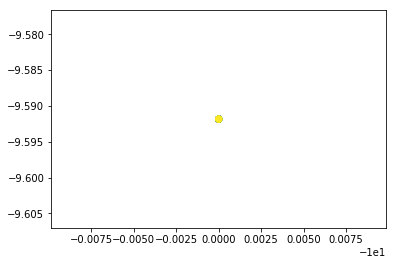

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs


(X_train, y_train) = make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=1.5, random_state=40)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

## Using Scikit-learn

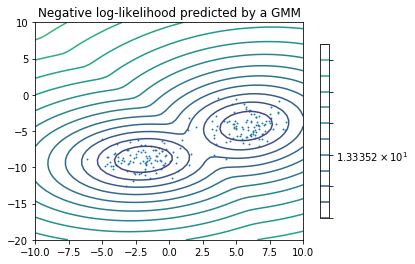

In [53]:
from matplotlib.colors import LogNorm
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-10., 10.)
y = np.linspace(-20., 10.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 25))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


## Naive Implementation


In [141]:
import scipy.stats

def predict(X, k):
    M, N = X.shape
    centroids_idx = np.random.choice(np.arange(X.shape[0]), k, replace=False)
    centroids = X[centroids_idx]
    
    mean_x = np.mean(X, axis=0)
    variances = np.sum(np.square(X - mean_x), axis=0) / (X.shape[0] - 1)
    priors = np.repeat(1/k, k)
    
    old_probabilities = None
    new_probabilities = np.zeros((X.shape[0], k))
    
    max_iterations = 50
    it = 0
    
    while (old_probabilities != new_probabilities).any() and it < max_iterations:
        old_probabilities = np.copy(new_probabilities)
        
        # expectation step
        for i, x in enumerate(X):
            normal_distributions = [scipy.stats.multivariate_normal(c, np.eye(N)*v) for c, v in zip(centroids, variances)]
            soft_assignments_probabilities = [nd.pdf(x)*prior for nd, prior in zip(normal_distributions, priors)]
            soft_assignments_probabilities = np.array(soft_assignments_probabilities)
            soft_assignments_probabilities = soft_assignments_probabilities / np.sum(soft_assignments_probabilities)
            
            new_probabilities[i] = soft_assignments_probabilities
        
        # maximization step
        for c in range(k):
            priors[c] = np.mean(new_probabilities[:, c], axis=0)
            sum_probabilities_k = np.sum(new_probabilities[:, c])
            centroids[c] = np.sum(X * new_probabilities[:, c].reshape(-1, 1), axis=0) / sum_probabilities_k
            variances = np.sum(np.square(X - centroids[c]) * new_probabilities[:, c].reshape(-1, 1), axis=0) / sum_probabilities_k 
            
        it += 1
    
    print("Done! #iterations: ", it)
    y_pred = np.array([np.argmin(np.linalg.norm(centroids - x, axis=1)) for x in X])
    return y_pred, centroids

Done! #iterations:  15


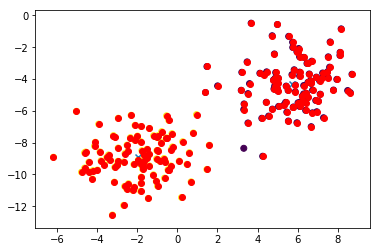

In [155]:
k = 2
y_pred, centroids = predict(X_train, k)

plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1, ], marker='x')


# plot misclassified points - makes sense only if k_true = k_fit
misclassified_points = X_train[y_train != y_pred]
plt.scatter(misclassified_points[:, 0], misclassified_points[:, 1], c='r')